# Gaussian priors in infinite dimensions

In this notebook we show how to construct PDE-based priors that lead to well-posed Bayesian inverse problems in infinite dimesions.
Specifically, we will consider a Gaussian prior $\mu_{\rm prior} \sim \mathcal{N}( m_{\rm prior}, \mathcal{C}_{\rm prior} )$, where
the covariance operator $\mathcal{C}_{\rm prior}$ is defined as the inverse of an elliptic differential operator, i.e.

$$ \mathcal{C}_{\rm prior} = \left( \delta I - \gamma \Delta \right)^{-\alpha}, $$

equipped with homogeneous Neumann, Dirichlet or Robin boundary conditions, and $m_{\rm prior} \in H^{\frac{\alpha}{2}}(\Omega)$, where $\Omega \subset \mathbb{R}^d$.

The parameter $\alpha > \frac{d}{2}$ controls the smoothness of the random field and ensures that $\mathcal{C}_{\rm prior}$ is a trace class operator (i.e., the infinite sum of the eigenvalues of  $\mathcal{C}_{\rm prior}$ is finite). 
The fact that $\mathcal{C}_{\rm prior}$ is trace class is extremely important as it guaratees that the pointwise variance of the samples is finite. (Recall that for a Gaussian random field 
$ E [\int_{\Omega}(m - m_{\rm prior})^2\,dx = \operatorname{trace}(\mathcal{C}_{\rm prior})]$).

The parameters $\delta>0$, $\gamma>0$ can be constant in $\Omega$ (in this case the prior is called stationary) or spatially varing. It can be shown that the correlation length $\rho$ of the Gaussian random field is proportional to $\sqrt{\frac{\gamma}{\delta}}$, while the marginal (pointwise) variance $\sigma^2$ is proportional to $\delta^{-2\alpha}\rho^{-d}$.

In addition, if one wants to introduce anysotropy in the correlation length, one can choose

$$ \mathcal{C}_{\rm prior} = \left( \delta I - \operatorname{div}(\Theta \nabla) \right)^{-2 \alpha}, $$

where $\Theta \in \mathbb{R}^{d\times d}$ is a symmetric positive definite tensor, with eigenvalues $\gamma_i > 0$ ($i=1,\ldots,d$) and orthonormal eigenvectors $\boldsymbol{v}_i$ ($i=1,\ldots,d$). In this case the correlation length in the direction $\boldsymbol{v}_i$ is proportional to $\sqrt{\frac{\gamma_i}{\delta}}$.

## Mesh dependence issues when sampling from a non-trace class operator

Here we consider the case when $\alpha <= \frac{d}{2}$ and we show that this leads to samples whose stastical properties depends on the spatial discretization.

In particular, we take $d=2$ and consider a Laplace-like prior $\mathcal{C}_{\rm prior} = \left( \delta I - \gamma \Delta \right)^{-1}$, i.e., the case $\alpha = 1$. 

We consider three triangulation of the unit square domain $\Omega = (0,1)^2$: a coarse mesh, a fine mesh, and a locally refined mesh where the mesh size varies. 

We let $\delta = 25.$ and $\gamma = 1.$, so that the correlation length $\rho$ is of the order of $0.2$.

In [1]:
import dolfin as dl
import numpy as np
import math
from hippylib import *

import matplotlib.pyplot as plt
%matplotlib inline

def locallyRefinedMesh():
    mesh = dl.UnitSquareMesh(16,16)
    
    for i in range(4):
        cell_markers = dl.CellFunction("bool", mesh)
        cell_markers.set_all(False)
        for cell in dl.cells(mesh):
            if cell.midpoint()[1] < .7 and cell.midpoint()[1] > .3 and cell.midpoint()[0] > .2 and cell.midpoint()[0] < .5:
                cell_markers[cell] = True
            
        mesh = dl.refine(mesh, cell_markers)
        
    return mesh

def generateSamples(mesh, gamma, delta, alpha):
    Vh = dl.FunctionSpace(mesh, "CG", 1)
    if np.abs(alpha - 1.0) < np.finfo(float).eps:
        prior = LaplacianPrior(Vh, gamma, delta)
        prior.Rsolver = dl.PETScLUSolver() #Replace iterative with direct solver
        prior.Rsolver.set_operator(prior.R)
    elif np.abs(alpha - 2.0) < np.finfo(float).eps:
        prior = BiLaplacianPrior(Vh, gamma, delta)
        prior.Asolver = dl.PETScLUSolver() #Replace iterative with direct solver
        prior.Asolver.set_operator(prior.A)
    else:
        raise InputError("Invalid alpha")
    
    noise = dl.Vector()
    prior.init_vector(noise, "noise")
    
    sample = dl.Vector()
    prior.init_vector(sample, 0)
    
    ss = []
    
    for i in range(3):
        parRandom.normal(1., noise)
        prior.sample(noise, sample)
        ss.append(vector2Function(sample, Vh))
        
    nb.multi1_plot(ss, ["sample 1", "sample 2", "sample 3"])
    
def pointwiseVariance(mesh, gamma, delta, alpha):
    Vh = dl.FunctionSpace(mesh, "CG", 1)
    if np.abs(alpha - 1.0) < np.finfo(float).eps:
        prior = LaplacianPrior(Vh, gamma, delta)
        prior.Rsolver = dl.PETScLUSolver() #Replace iterative with direct solver
        prior.Rsolver.set_operator(prior.R)
    elif np.abs(alpha - 2.0) < np.finfo(float).eps:
        prior = BiLaplacianPrior(Vh, gamma, delta)
        prior.Asolver = dl.PETScLUSolver() #Replace iterative with direct solver
        prior.Asolver.set_operator(prior.A)
    else:
        raise InputError("Invalid alpha")
    
    marginal_variance = prior.pointwise_variance(method="Exact")
    
    return vector2Function(marginal_variance, Vh)

def correlationStructure(prior, center):
    rhs = dl.Vector()
    prior.init_vector(rhs, 0)
    
    corrStruct = dl.Vector()
    prior.init_vector(corrStruct, 0)
    
    ps = dl.PointSource(prior.Vh, center, 1.)
    ps.apply(rhs)
    
    prior.Rsolver.solve(corrStruct, rhs)
    
    return vector2Function(corrStruct, prior.Vh)

## Generate the three meshes

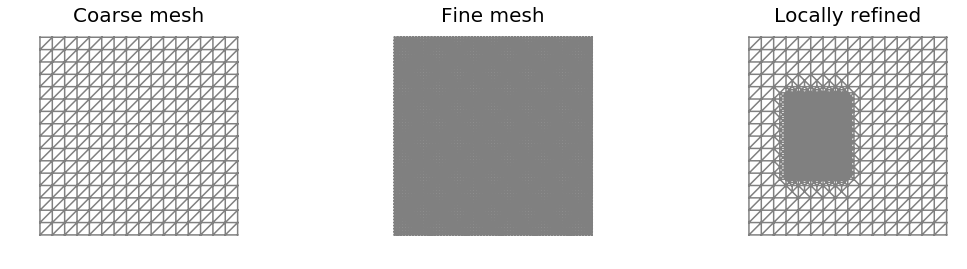

In [2]:
mesh1 = dl.UnitSquareMesh(16,16)
mesh2 = dl.UnitSquareMesh(64, 64)
mesh3 = locallyRefinedMesh()

nb.multi1_plot([mesh1, mesh2, mesh3], ["Coarse mesh", "Fine mesh", "Locally refined"])

## Generate samples from the Laplacian-like prior ($\alpha=1$)

By visually inspecting a few samples from a Laplacian-like prior in 2D we note that something is not quite right...

Samples look rougher where the mesh is finer.

Coarse mesh


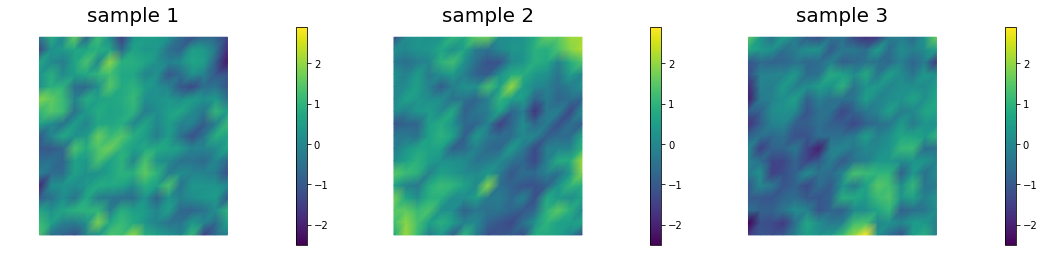

Fine mesh


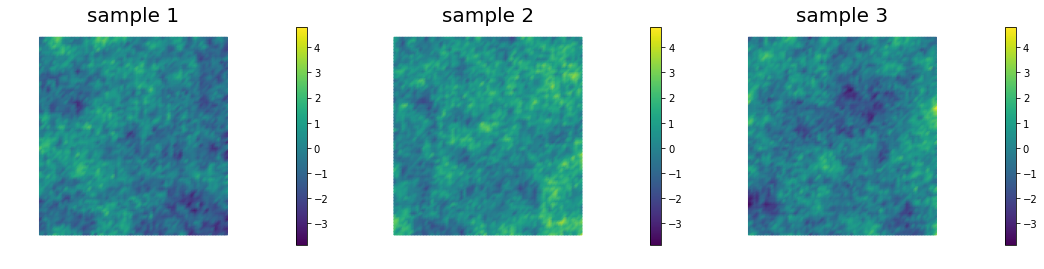

Locally refined mesh


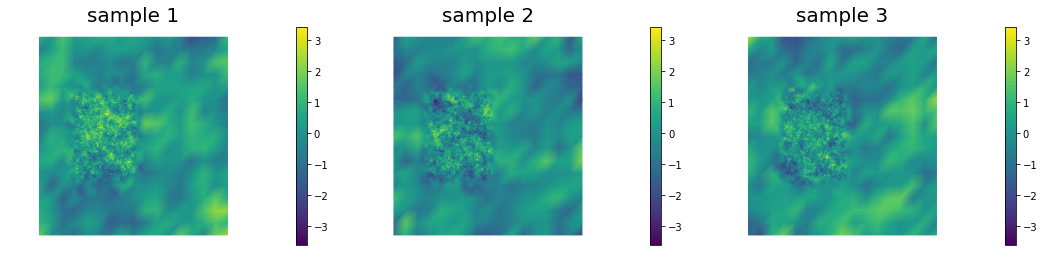

In [3]:
gamma = 1.
delta = 25.

print("Coarse mesh")
generateSamples(mesh1, gamma, delta, alpha=1.0)
plt.show()
print("Fine mesh")
generateSamples(mesh2, gamma, delta, alpha=1.0)
plt.show()
print("Locally refined mesh")
generateSamples(mesh3, gamma, delta, alpha=1.0)
plt.show()

## Pointwise variance for the Laplacian-like  prior ($\alpha=1$)

The pointwise variance is larger when the mesh is finer. In the limit for $h\rightarrow 0$ the pointwise variance becomes infinite.

Pointwise variance


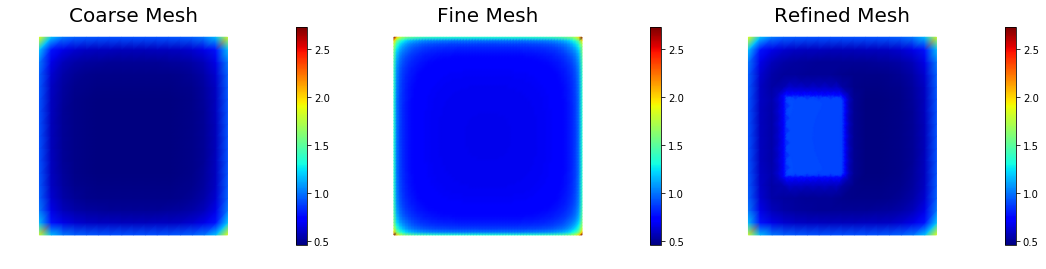

In [4]:
pt_1 = pointwiseVariance(mesh1, gamma, delta, alpha=1.)
pt_2 = pointwiseVariance(mesh2, gamma, delta, alpha=1.)
pt_3 = pointwiseVariance(mesh3, gamma, delta, alpha=1.)

print("Pointwise variance")
nb.multi1_plot([pt_1, pt_2, pt_3], ["Coarse Mesh", "Fine Mesh", "Refined Mesh"], same_colorbar=True, cmap='jet')

## Generate samples from Bilaplacian-like prior ($\alpha=2$)

Samples look qualitatively the same on different meshes. In fact, $\alpha=2$ is sufficient in 2D for defining a well-behaved prior and well-posed inverse problem.

Coarse mesh


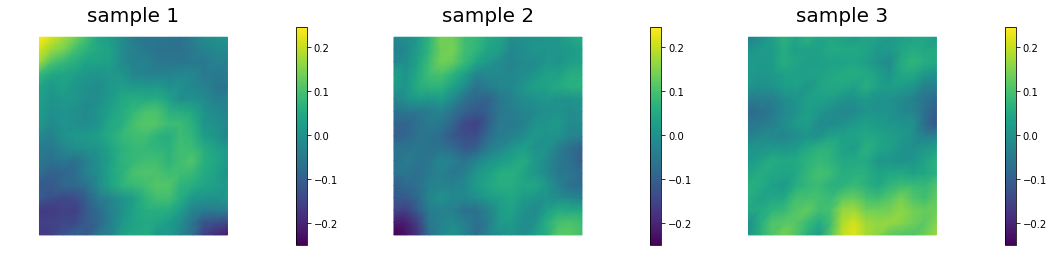

Fine mesh


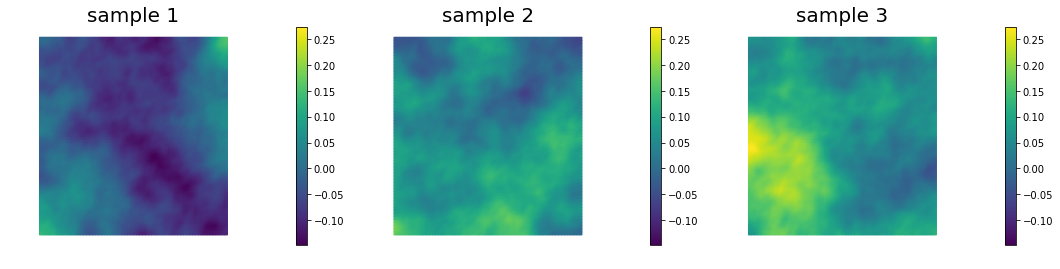

Locally refined mesh


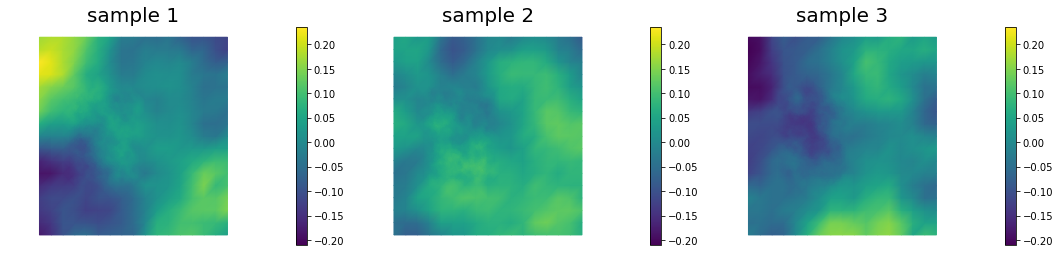

In [5]:
gamma = 1.
delta = 25.

print("Coarse mesh")
generateSamples(mesh1, gamma, delta, alpha=2.0)
plt.show()
print("Fine mesh")
generateSamples(mesh2, gamma, delta, alpha=2.0)
plt.show()
print("Locally refined mesh")
generateSamples(mesh3, gamma, delta, alpha=2.0)
plt.show()

## Pointwise variance for the Bilaplacian-like  prior ($\alpha=2$)

The pointwise variance is independent of the mesh resolution. This is because $\alpha = 2$ gives a covariance belonging to the space of trace-class operators.

Pointwise variance


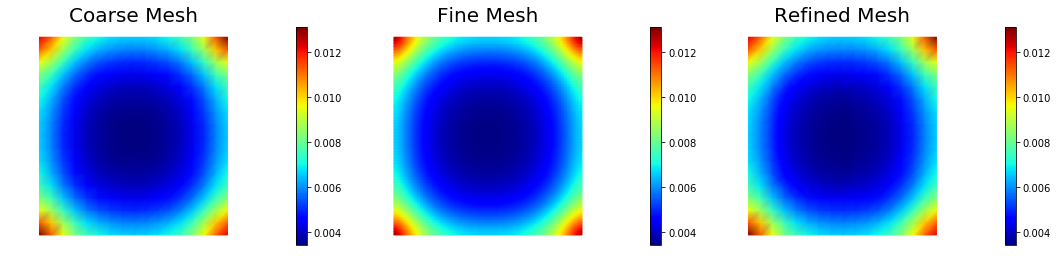

In [6]:
pt_1 = pointwiseVariance(mesh1, gamma, delta, alpha=2.)
pt_2 = pointwiseVariance(mesh2, gamma, delta, alpha=2.)
pt_3 = pointwiseVariance(mesh3, gamma, delta, alpha=2.)

print("Pointwise variance")
nb.multi1_plot([pt_1, pt_2, pt_3], ["Coarse Mesh", "Fine Mesh", "Refined Mesh"], same_colorbar=True, cmap='jet')

## Boundary artifacts

The above figure shows that the pointwise variance is larger close to the boundary of the domain than in the interior. This boundary artifact is due to the use on natural (homogeneous Neumann) boundary condition. Similar artifacts occur if one uses homogeneous Dirichlet boundary conditions.

To mitigate these boundary effects one could instead consider Robin boundary conditions of the form

$$ \nabla m \cdot \boldsymbol{n} + \beta m = 0 \text{ on } \partial\Omega, $$

where the value $\beta = \frac{\sqrt{\gamma\delta}}{1.42}$ has empirically be found to be a good choice.

The figure below show the pointwise variance using both natural and Robin boundary conditions.

Pointwise variance


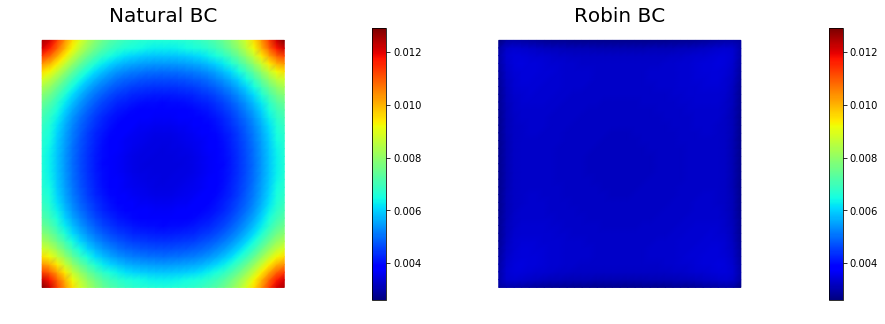

In [7]:
gamma = 1.
delta = 25.

mesh = dl.UnitSquareMesh(32,32)
Vh = dl.FunctionSpace(mesh, "CG", 1)

prior_natural = BiLaplacianPrior(Vh, gamma, delta,  robin_bc=False)
prior_robin = BiLaplacianPrior(Vh, gamma, delta,  robin_bc=True)


## pointwise variance 
pointwise_variance_natural = vector2Function(prior_natural.pointwise_variance(method="Exact"), Vh)
pointwise_variance_robin = vector2Function(prior_robin.pointwise_variance(method="Exact"), Vh)

print("Pointwise variance")
nb.multi1_plot([pointwise_variance_natural, pointwise_variance_robin], ["Natural BC", "Robin BC"],
               same_colorbar = True, cmap='jet')
plt.show()

## Anysotropic correlation lengths
$\newcommand{\prcov}{\mathcal{C}_{\rm prior}}$

Here we assume a Gaussian prior, $\mu_{\rm prior} \sim \mathcal{N}(0, \prcov)$ with zero mean and covariance matrix $\prcov = \mathcal{A}^{-2}$, where $\mathcal{A}$ is a differential operator of the form

$$ \mathcal{A} = -\gamma {\nabla\cdot}\, \left(\Theta\, {\nabla}\right) + \delta I. $$

Here $\Theta$ is a s.p.d. anisotropic tensor of the form

$$ \Theta =
\begin{bmatrix}
\theta_1 \sin^2\alpha & (\theta_1-\theta_2) \sin\alpha\, \cos{\alpha} \\
(\theta_1-\theta_2) \sin\alpha\, \cos{\alpha} & \theta_2 \cos^2\alpha.
\end{bmatrix}.
$$

This allows to generate distributions that have large correlation lenght in some directions, which can be useful in prior modeling. Below we show samples from the resulting distribution, the pointwise variance as well as a covariance function for the center of the domain. 

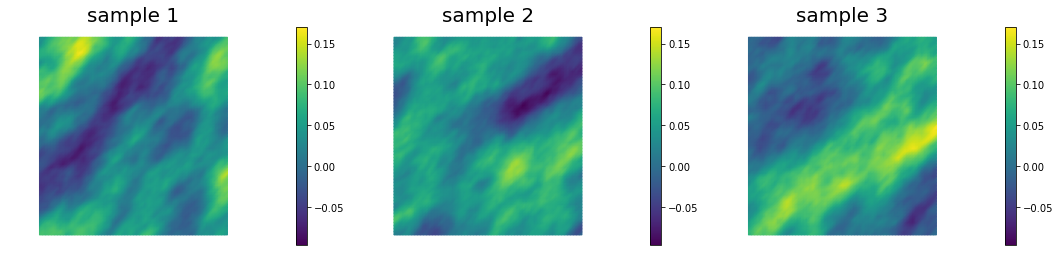

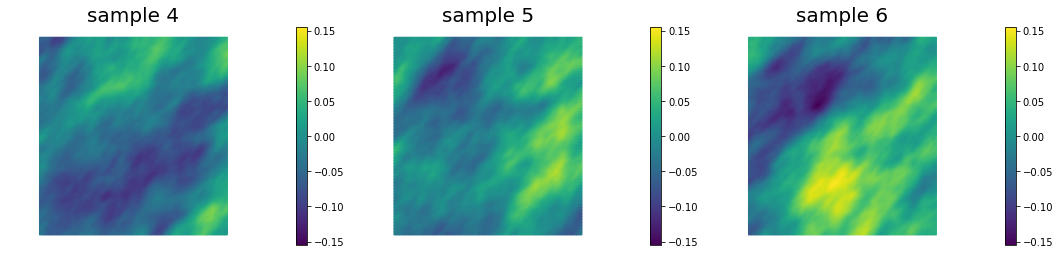

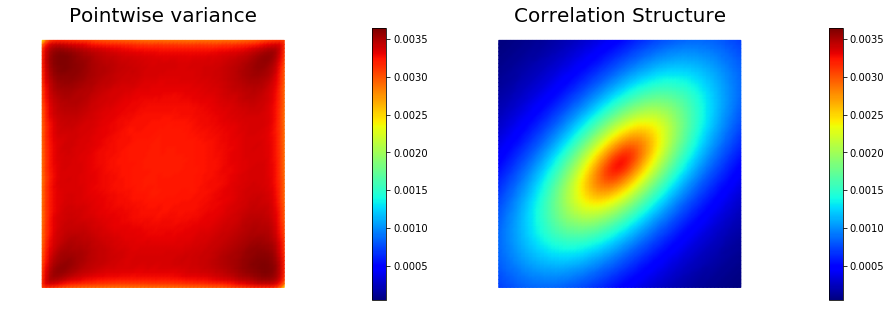

In [8]:
gamma = 1.
delta = 25.

mesh = dl.UnitSquareMesh(64,64)
Vh = dl.FunctionSpace(mesh, "CG", 1)
    
anis_diff = dl.Expression(code_AnisTensor2D, degree=1)
anis_diff.theta0 = 2.
anis_diff.theta1 = .5
anis_diff.alpha = math.pi/4
prior = BiLaplacianPrior(Vh, gamma, delta, anis_diff, robin_bc=True)

## Generate and show 6 samples
noise = dl.Vector()
prior.init_vector(noise, "noise")
    
sample = dl.Vector()
prior.init_vector(sample, 0)
    
ss = []
    
for i in range(6):
    parRandom.normal(1., noise)
    prior.sample(noise, sample)
    ss.append(vector2Function(sample, Vh))
        
nb.multi1_plot(ss[0:3], ["sample 1", "sample 2", "sample 3"])
nb.multi1_plot(ss[3:6], ["sample 4", "sample 5", "sample 6"])
plt.show()

## pointwise variance and correlation structure

pointwise_variance = vector2Function(prior.pointwise_variance(method="Randomized", r=200), Vh)
correlation_struc  = correlationStructure(prior, dl.Point(.5,.5))

nb.multi1_plot([pointwise_variance, correlation_struc], ["Pointwise variance", "Correlation Structure"],
               same_colorbar = True, cmap='jet')
plt.show()

Copyright &copy; 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.